Francis Deck

    The MIT License (MIT) Copyright (c) 2018-2021 Francis Deck

    Permission is hereby granted, free of charge, to any person obtaining a copy of this 
    software and associated documentation files (the "Software"), to deal in the Software 
    without restriction, including without limitation the rights to use, copy, modify, 
    merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
    to permit persons to whom the Software is furnished to do so, subject to the 
    following conditions:

    The above copyright notice and this permission notice shall be included in all 
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
    INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
    PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
    HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION 
    OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
    SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [97]:
# Driver library

emi2512ii = { # Eminence DeltaLite 2512-ii
    'F_s': 37, # resonant frequency in Hz
    'R_e': 5.04, # series resistance of voice coil in Ohms
    'L_e': 0.46*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 3.13, # mechanical contribution to Q factor
    'Q_es': 0.44, # electromagnetic contribution to Q factor
    'Vas': 147*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 4.90*0.001, # maximum excursion, converted from mm to m
    'S_d': 519.5/1e4, # cone area converted from cm^2 to m^2
}

driver2 = dict(emi2512ii)
driver2['S_d'] = emi2512ii['S_d']*2
driver2['Vas'] = emi2512ii['Vas']*2

kl3012cx = { # Eminence KappaLite 3012CX
    'F_s': 42, # resonant frequency in Hz
    'R_e': 5.7, # series resistance of voice coil in Ohms
    'L_e': 0.61*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 8.37, # mechanical contribution to Q factor
    'Q_es': 0.31, # electromagnetic contribution to Q factor
    'Vas': 111.5*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 7.47*0.001, # maximum excursion, converted from mm to m
    'S_d': 545.4/1e4, # cone area converted from cm^2 to m^2
}

bc15cl76 = { # B&C 15CL76
    'F_s': 42, # resonant frequency in Hz
    'R_e': 5.1, # series resistance of voice coil in Ohms
    'L_e': 0.34*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 7.9, # mechanical contribution to Q factor
    'Q_es': 0.33, # electromagnetic contribution to Q factor
    'Vas': 135*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 7.0*0.001, # maximum excursion, converted from mm to m
    'S_d': 855/1e4, # cone area converted from cm^2 to m^2
}

# Box database

box1 = { # My little 12" box
    'Znom': 8,
    'Pin': Pin,
    'V_box': 32*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 50,
    'd_port': 100*0.01, # diameter of port in cm converted to m
}

# Box database

box1a = { # My little 12" box
    'Znom': 8,
    'Pin': Pin,
    'V_box': 64*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 50,
    'd_port': 100*0.01, # diameter of port in cm converted to m
}

# The two boxes of this TalkBass thread... I think
# Didn't check the exact port dimensions
# https://www.talkbass.com/threads/mixed-cab-design-case-study.1567575/

box2 = {
    'Znom': 8,
    'Pin': Pin,
    'V_box': 51.2*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 55.5, # port tuning frequency in Hz
    'Q_port': 50,
    'd_port': 100*0.01, # diameter of port in cm converted to m
}

box3 = {
    'Znom': 8,
    'Pin': Pin,
    'V_box': 54.9*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 55.5, # port tuning frequency in Hz
    'Q_port': 50,
    'd_port': 100*0.01, # diameter of port in cm converted to m
}

In [89]:
from numpy import * # array math library
%matplotlib inline
from matplotlib.pyplot import *

gamma = 1.4 # adiabatic constant, dimensionless
P_atm = 101325 # atmospheric pressure, Pa
rho = 1.225 # density of air, kg/m^3
c = 345 # speed of sound in air

f = logspace(1, 3, 300) # a range of frequencies from 10 to 1000 Hz

verbose = False

def xCone(w = 2*pi*f, **kwargs):
    w_0 = 2*pi*kwargs['F_s'] # resonant frequency in radians/s
    m = gamma*P_atm*kwargs['S_d']**2/w_0**2/kwargs['Vas'] # cone mass in kg
    BL = sqrt(w_0*m*kwargs['R_e']/kwargs['Q_es']) # BL product in T*m
    C = w_0*m/kwargs['Q_ms'] # Mechanical damping constant of cone
    K = w_0**2*m # Spring constant of cone
    r = sqrt(kwargs['S_d']/pi) # Radius
    z = kwargs['R_e'] + 1j*w*kwargs['L_e'] # Electrical impedance
    K_box = gamma*P_atm*kwargs['S_d']**2/kwargs['V_box'] # Spring constant of box
    Vrms = sqrt(kwargs['Pin']*kwargs['Znom']) # Input voltage in Volts RMS
        
    if kwargs['ported']:
        w_port = 2*pi*kwargs['f_port'] # port resonant frequency in radians/s
        kappa = w**2/(w**2 - 1j*w*w_port/kwargs['Q_port'] - w_port**2)
    else:
        kappa = 1

    Keff = K + kappa*K_box
    x = BL*Vrms/m/z/(Keff/m + 1j*w*(BL**2/m/z + C/m) - w**2)
    
    # Impedance, complex valued

    Z = z/(1 - 1j*w*BL*x/Vrms)

    # Listening distance, 1 meter

    R = 1

    # Sound pressure at listening distance

    p = rho*r**2*w**2*kappa*x/R/2
    p_ref = 20e-6 # reference pressure in Pa RMS

    # Sound pressure level in dB SPL

    spl = 20*log10(abs(p)/p_ref)
    
    phase = angle(kappa*x)*180/pi
    
    
    # More ported behavior
    
    if kwargs['ported']:
        kappa2 = w_port**2/(w**2 - 1j*w*w_port/kwargs['Q_port'] - w_port**2)
        Keff = K + kappa*K_box
        S_port = pi*kwargs['d_port']/4
        x = BL*Vrms/m/z/(Keff/m + 1j*w*(BL**2/m/z + C/m) - w**2)
        v_port = 1j*w* kappa2*x*kwargs['S_d']/S_port       
    else:
        v_port = None
        
    if verbose:
        print('resonant angular frequency w_0 (1/s) = ', w_0)
        print('cone mass m (kg) = ', m)
        print('magnetic field length product BL (T m) = ', BL)
        print('mechanical damping factor (N/(m/s)) = ', C)
        print('mechanical spring constant (N/m)', K)
        print('mechanical compliance (m/N)', 1/K)
        print('cone radius (m) =', r)
        print('box spring constant (N/m)', K_box)
        print('Port angular frequency (1/s)', w_port)
        
    return x, Z, spl, phase, v_port, p

def graphs(f, x, Z, spl, phase, v_port):
    ax[0].semilogx(f, abs(x)*1000*1.414, label = label)
    ax[0].set_xlabel('frequency (Hz)')
    ax[0].set_ylabel('cone excursion amplitude (mm)')
    ax[0].legend()
    
    ax[1].semilogx(f, abs(Z))
    ax[1].set_xlabel('frequency (Hz)')
    ax[1].set_ylabel('impedance ($\Omega$)')

    ax[2].semilogx(f, spl)
    ax[2].set_xlabel('Frequency (Hz)')
    ax[2].set_ylabel('Sound pressure (dB SPL)')

    ax[3].semilogx(f, phase)
    ax[3].set_xlabel('Frequency (Hz)')
    ax[3].set_ylabel('Phase')

    ax[4].semilogx(f, abs(v_port)*1000*1.414/c)
    ax[4].set_xlabel('frequency (Hz)')
    ax[4].set_ylabel('port air speed (mach)')

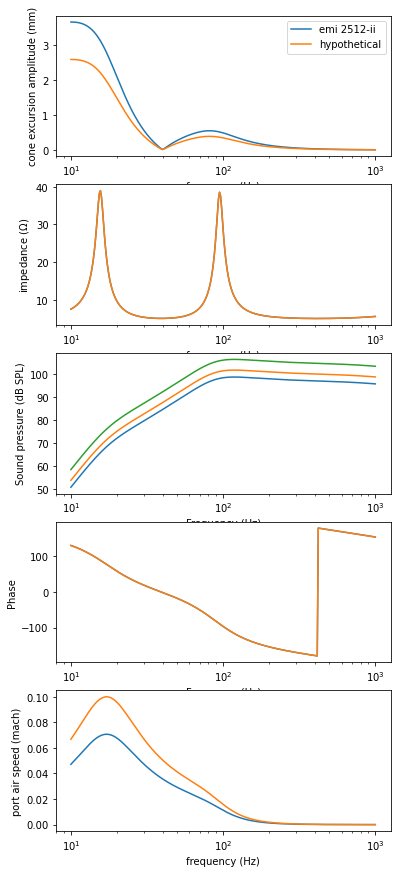

In [98]:
fig, ax = subplots(5, 1, figsize = (6, 15))

label = 'emi 2512-ii'
x, Z, spl, phase, v_port, p1 = xCone(**(emi2512ii | box1)) 
graphs(f, x, Z, spl, phase, v_port)

label = 'hypothetical'
x, Z, spl, phase, v_port, p2 = xCone(**(driver2 | box1a)) 
graphs(f, x, Z, spl, phase, v_port)

#label = 'kl3012cx'
#x, Z, spl, phase, v_port, p1 = xCone(**(kl3012cx | box2)) 
#graphs(f, x, Z, spl, phase, v_port)

#label = 'bc15cl76'
#x, Z, spl, phase, v_port, p2 = xCone(**(bc15cl76 | box3)) 
#graphs(f, x, Z, spl, phase, v_port)

# Combine the two sound pressure values

p_ref = 20e-6 # reference pressure in Pa RMS
spl = 20*log10(abs(p1 + p2)/p_ref)
ax[2].semilogx(f, spl)

In [96]:
emi2510ii

{'F_s': 37,
 'R_e': 5.04,
 'L_e': 0.00046,
 'Q_ms': 3.13,
 'Q_es': 0.44,
 'Vas': 0.147,
 'Xmax': 0.004900000000000001,
 'S_d': 0.05195}